## Module imports

In [1]:
from importlib import reload
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import math
import collections
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import EMNIST, MNIST, SVHN, FashionMNIST, CIFAR10
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights, resnet50, ResNet50_Weights
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')
from matplotlib import rcParams; rcParams['font.family'] = 'serif'

# local imports
from data import subset, simple_DS
import valuation 
reload(valuation)
from valuation import get_volume, div_rel_func, cluster_valuation
import utils

import clip
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
import time
from sklearn.cluster import KMeans

In [2]:
root = Path('../data/') # path to data directory
download = True # dowload data if dataset does not exist in data directory

mnist_buyer = MNIST(root=root, train=False, download=download)
mnist_seller = MNIST(root=root, train=True, download=download)
fashion_seller = FashionMNIST(root=root, train=False, download=download)
emnist_seller = EMNIST(root=root, split='byclass', train=False, download=download)
svhn_seller = SVHN(root=root, download=download) 
cifar_seller = CIFAR10(root=root, train=False, download=download)

Using downloaded and verified file: ../data/train_32x32.mat
Files already downloaded and verified


In [3]:
# model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
# model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# model = resnet50(weights=ResNe t50_Weights.IMAGENET1K_V1).cuda()
model, preprocess = clip.load("ViT-B/16", device='cuda')
model.eval();

100%|███████████████████████████████████████| 335M/335M [00:05<00:00, 61.5MiB/s]


In [10]:
torch.tensor(cifar_seller.targets)

tensor([3, 8, 8,  ..., 5, 1, 7])

In [11]:
make_loader = lambda x, batch_size=16: torch.utils.data.DataLoader(
    simple_DS(x, transforms=Compose([ToPILImage(), preprocess])), 
    batch_size=batch_size,
)
data_dict = dict(
    mnist_buyer=mnist_buyer.data, 
    mnist_seller=mnist_seller.data, 
    fashion_seller=fashion_seller.data, 
    cifar_seller=cifar_seller.data, 
    emnist_seller=emnist_seller.data.moveaxis(1, -1),
    svhn_seller=np.moveaxis(svhn_seller.data, 1, -1),
)
target_dict = dict(
    mnist_buyer=mnist_buyer.targets, 
    mnist_seller=mnist_seller.targets, 
    fashion_seller=fashion_seller.targets, 
    cifar_seller=cifar_seller.targets, 
    emnist_seller=emnist_seller.targets,
    svhn_seller=svhn_seller.labels,
)

num_samples = None
features_dict = {
    k: {
        'images': torch.cat([model.encode_image(x.cuda()).detach().cpu() for x in tqdm(make_loader(v[:None if k == 'mnist_seller' else num_samples]))]),
        'labels': target_dict[k]
       }
    for k, v in data_dict.items()
}

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/7271 [00:00<?, ?it/s]

  0%|          | 0/4579 [00:00<?, ?it/s]

In [12]:
embed_dir = Path('embeddings')
embed_dir.mkdir(exist_ok=True)
for k, v in features_dict.items():
    torch.save(v, embed_dir / f'clip_embedding_{k}.pt')

In [6]:
num_buyer = 1000
num_seller = 10000

buyer_data = features_dict['mnist_buyer'][subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))][:num_buyer]
seller_1_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', ))][:num_seller]
seller_2_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', ))][:num_seller]
seller_3_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', ))][:num_seller]
seller_4_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', ))][:num_seller]
seller_5_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', ))][:num_seller]
seller_6_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', ))][:num_seller]
seller_7_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', ))][:num_seller]
seller_8_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', ))][:num_seller]
seller_9_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', ))][:num_seller]
seller_10_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))][:num_seller]

emnist_data = features_dict['emnist_seller'][subset(emnist_seller, ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'))[:num_samples]][:num_seller]
fashion_data = features_dict['fashion_seller'][:num_seller]
svhn_data = features_dict['svhn_seller'][:num_seller]
cifar_data = features_dict['cifar_seller'][:num_seller]

print(buyer_data.shape)
print(seller_1_data.shape)
print(seller_2_data.shape)
print(seller_3_data.shape)
print(seller_4_data.shape)
print(seller_5_data.shape)
print(seller_6_data.shape)
print(seller_7_data.shape)
print(seller_8_data.shape)
print(seller_9_data.shape)
print(emnist_data.shape)
print(fashion_data.shape)
print(svhn_data.shape)
print(cifar_data.shape)

torch.Size([1000, 512])
torch.Size([5923, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([2656, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])


In [7]:
threshold = 0.1
n_components = 10
omega = 0.1
norm_volume=False
kwargs= dict(threshold =threshold, n_components =n_components, omega = omega, norm_volume=norm_volume)

In [8]:
buyer_values = get_value(buyer_data, buyer_data, **kwargs)
seller_1_values = get_value(buyer_data, seller_1_data, **kwargs)
seller_2_values = get_value(buyer_data, seller_2_data, **kwargs)
seller_3_values = get_value(buyer_data, seller_3_data, **kwargs)
seller_4_values = get_value(buyer_data, seller_4_data, **kwargs)
seller_5_values = get_value(buyer_data, seller_5_data, **kwargs)
seller_6_values = get_value(buyer_data, seller_6_data, **kwargs)
seller_7_values = get_value(buyer_data, seller_7_data, **kwargs)
seller_8_values = get_value(buyer_data, seller_8_data, **kwargs)
seller_9_values = get_value(buyer_data, seller_9_data, **kwargs)
seller_10_values = get_value(buyer_data, seller_10_data, **kwargs)

NameError: name 'get_value' is not defined

In [ ]:
emnist_values = get_value(buyer_data, emnist_data, **kwargs)
svhn_values = get_value(buyer_data, svhn_data, **kwargs)
fashion_values = get_value(buyer_data, fashion_data, **kwargs)
cifar_values = get_value(buyer_data, cifar_data, **kwargs)

In [ ]:
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, 10).astype(int)]
s = 150
plt.scatter(buyer_values['relevance'], buyer_values['volume'], label='buyer: 0, 1, 2, 3, 4', s=s, marker='o')
plt.scatter(seller_1_values['relevance'], seller_1_values['volume'], color=colors[0], s=s, marker='o', label='Seller 1: 0')
plt.scatter(seller_2_values['relevance'], seller_2_values['volume'], color=colors[1], s=s, marker='o', label='Seller 2: 0, 1')
plt.scatter(seller_3_values['relevance'], seller_3_values['volume'], color=colors[2], s=s, marker='o', label='Seller 3: 0, 1, 2')
plt.scatter(seller_4_values['relevance'], seller_4_values['volume'], color=colors[3], s=s, marker='o', label='Seller 4: 0, 1, 2, 3')
plt.scatter(seller_5_values['relevance'], seller_5_values['volume'], color=colors[4], s=s, marker='o', label='Seller 5: 0, 1, 2, 3, 4')
plt.scatter(seller_6_values['relevance'], seller_6_values['volume'], color=colors[5], s=s, marker='D', label='Seller 6: 0, 1, 2, 3, 4, 5')
plt.scatter(seller_7_values['relevance'], seller_7_values['volume'], color=colors[6], s=s, marker='D', label='Seller 7: 0, 1, 2, 3, 4, 5, 6')
plt.scatter(seller_8_values['relevance'], seller_8_values['volume'], color=colors[7], s=s, marker='D', label='Seller 8: 0, 1, 2, 3, 4, 5, 6, 7')
plt.scatter(seller_9_values['relevance'], seller_9_values['volume'], color=colors[8], s=s, marker='D', label='Seller 9: 0, 1, 2, 3, 4, 5, 6, 7, 8')
plt.scatter(seller_10_values['relevance'], seller_10_values['volume'], color=colors[9], s=s, marker='D', label='Seller 10: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9')
plt.scatter(emnist_values['relevance'], emnist_values['volume'], color='C1', s=s, marker='X', label='EMNIST Seller ')
plt.scatter(fashion_values['relevance'], fashion_values['volume'], color='C2', s=s, marker='X', label='Fashion Seller ')
plt.scatter(cifar_values['relevance'], cifar_values['volume'], color='C3', s=s, marker='X', label='CIFAR Seller ')
plt.yscale('log')
plt.xlim(0.0, 1.05)
plt.xlabel('Relevance', fontsize=20)
plt.ylabel('Diversity', fontsize=20)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.00, 1.00), ncol=1)
# plt.savefig(f'figures/mnist-diversity.png', bbox_inches='tight')

In [ ]:
def cluster_valuation(buyer_data, seller_data, k_means=None, n_clusters=10, n_components=25):
    if k_means is None:
        k_means = KMeans(n_clusters=n_clusters, n_init='auto')
        k_means.fit(buyer_data)
    buyer_clusters = {k: buyer_data[k_means.predict(buyer_data) == k] for k in range(n_clusters)}
    print('buyer', [len(v) for v in buyer_clusters.values()])
    seller_clusters = {k: seller_data[k_means.predict(seller_data) == k] for k in range(n_clusters)}
    print('seller', [len(v) for v in buyer_clusters.values()])
    cluster_rel = {}
    cluster_vol = {}
    # for j in tqdm(range(n_clusters)):
    for j in range(n_clusters):
        # cluster_pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
        # cluster_pca.fit(buyer_clusters[j])
        ws = []
        rs = []
        vs = []
        for i in range(n_clusters):
            if seller_clusters[i].shape[0] == 0 or seller_clusters[i].shape[0] == 1:
                ws.append(0)
                rs.append(0)
                vs.append(0)
            else:
                values = get_value(buyer_clusters[j], seller_clusters[i], n_components=n_components)
                ws.append(seller_clusters[i].shape[0] / seller_data.shape[0])
                rs.append(values['relevance'])
                vs.append(values['volume'])
                # rs.append(valuation.get_relevance(cluster_pca, seller_clusters[i]))
                # vs.append(valuation.get_volume(np.cov(cluster_pca.transform(seller_clusters[i]).T)))
        cluster_rel[j] = np.average(rs, weights=ws)
        cluster_vol[j] = np.average(vs, weights=ws)
    buyer_weights = [v.shape[0] / buyer_data.shape[0] for v in buyer_clusters.values()]
    # print(buyer_weights)
    rel = np.average(list(cluster_rel.values()), weights=buyer_weights)
    vol = np.average(list(cluster_vol.values()), weights=buyer_weights)
    return rel, vol

In [ ]:
for n_clusters in (10, 15):
    s = 150
    plt.scatter(*cluster_valuation(buyer_data, np.array(fashion_seller_features, dtype=np.double), n_clusters=n_clusters, n_components=n_components), color='C1', s=s, marker='X', label='Seller fashion')
    plt.scatter(*cluster_valuation(buyer_data, buyer_data, n_clusters=n_clusters, n_components=n_components), label='buyer: 0, 1, 2, 3, 4', s=s, marker='o')
    plt.scatter(*cluster_valuation(buyer_data, seller_1_data, n_clusters=n_clusters, n_components=n_components), color=colors[0], s=s, marker='o', label='Seller 1: 0')
    plt.scatter(*cluster_valuation(buyer_data, seller_2_data, n_clusters=n_clusters, n_components=n_components), color=colors[1], s=s, marker='o', label='Seller 2: 0, 1')
    plt.scatter(*cluster_valuation(buyer_data, seller_3_data, n_clusters=n_clusters, n_components=n_components), color=colors[2], s=s, marker='o', label='Seller 3: 0, 1, 2')
    plt.scatter(*cluster_valuation(buyer_data, seller_4_data, n_clusters=n_clusters, n_components=n_components), color=colors[3], s=s, marker='o', label='Seller 4: 0, 1, 2, 3')
    plt.scatter(*cluster_valuation(buyer_data, seller_5_data, n_clusters=n_clusters, n_components=n_components), color=colors[4], s=s, marker='o', label='Seller 5: 0, 1, 2, 3, 4')
    plt.scatter(*cluster_valuation(buyer_data, seller_6_data, n_clusters=n_clusters, n_components=n_components), color=colors[5], s=s, marker='D', label='Seller 6: 0, 1, 2, 3, 4, 5')
    plt.scatter(*cluster_valuation(buyer_data, seller_7_data, n_clusters=n_clusters, n_components=n_components), color=colors[6], s=s, marker='D', label='Seller 7: 0, 1, 2, 3, 4, 5, 6')
    plt.scatter(*cluster_valuation(buyer_data, seller_8_data, n_clusters=n_clusters, n_components=n_components), color=colors[7], s=s, marker='D', label='Seller 8: 0, 1, 2, 3, 4, 5, 6, 7')
    plt.scatter(*cluster_valuation(buyer_data, seller_9_data, n_clusters=n_clusters, n_components=n_components), color=colors[8], s=s, marker='D', label='Seller 9: 0, 1, 2, 3, 4, 5, 6, 7, 8')
    plt.scatter(*cluster_valuation(buyer_data, seller_10_data, n_clusters=n_clusters, n_components=n_components),color=colors[9], s=s, marker='D', label='Seller 10: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9')
    plt.scatter(*cluster_valuation(buyer_data, emnist_data, n_clusters=n_clusters, n_components=n_components), color='C1', s=s, marker='X', label='EMNIST Seller ')
    plt.scatter(*cluster_valuation(buyer_data, fashion_data, n_clusters=n_clusters, n_components=n_components), color='C2', s=s, marker='X', label='Fashion Seller ')
    plt.scatter(*cluster_valuation(buyer_data, cifar_data, n_clusters=n_clusters, n_components=n_components), color='C3', s=s, marker='X', label='CIFAR Seller ')
    plt.yscale('log')
    plt.xlim(0.0, 1.05)
    plt.xlabel('Relevance', fontsize=20)
    plt.ylabel('Diversity', fontsize=20)
    plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.00, 1.00), ncol=1)
    plt.title(f'{n_clusters=}  {n_components=}')
    # plt.savefig(f'figures/cluster-{n_clusters=}-{n_components=}.png', bbox_inches='tight')
    plt.show()

buyer [128, 100, 80, 109, 169, 49, 99, 126, 44, 96]
seller [128, 100, 80, 109, 169, 49, 99, 126, 44, 96]
buyer [265, 73, 80, 51, 90, 86, 107, 106, 75, 67]
seller [265, 73, 80, 51, 90, 86, 107, 106, 75, 67]
buyer [39, 99, 97, 51, 79, 132, 168, 126, 94, 115]
seller [39, 99, 97, 51, 79, 132, 168, 126, 94, 115]
buyer [207, 168, 83, 51, 121, 35, 107, 89, 42, 97]
seller [207, 168, 83, 51, 121, 35, 107, 89, 42, 97]


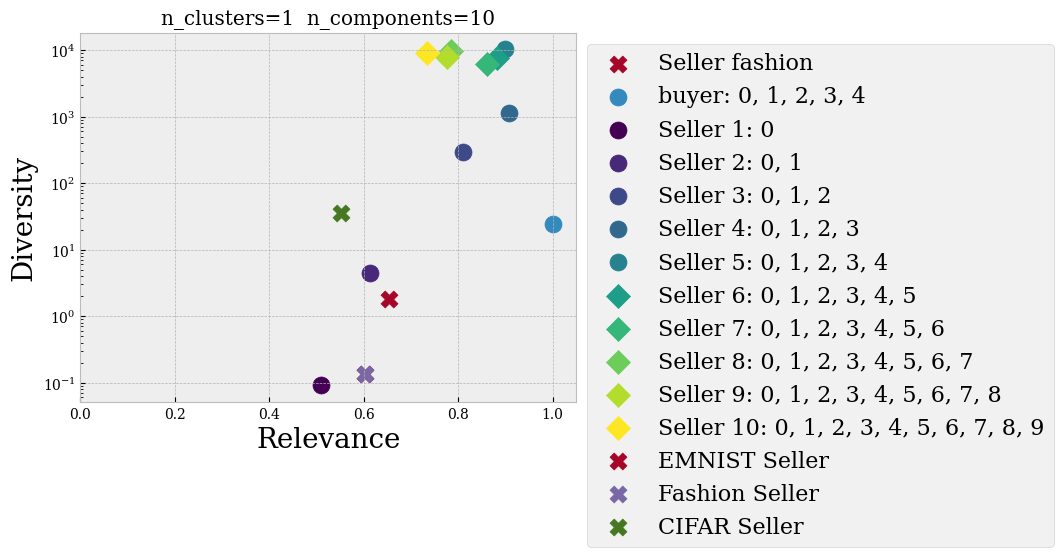

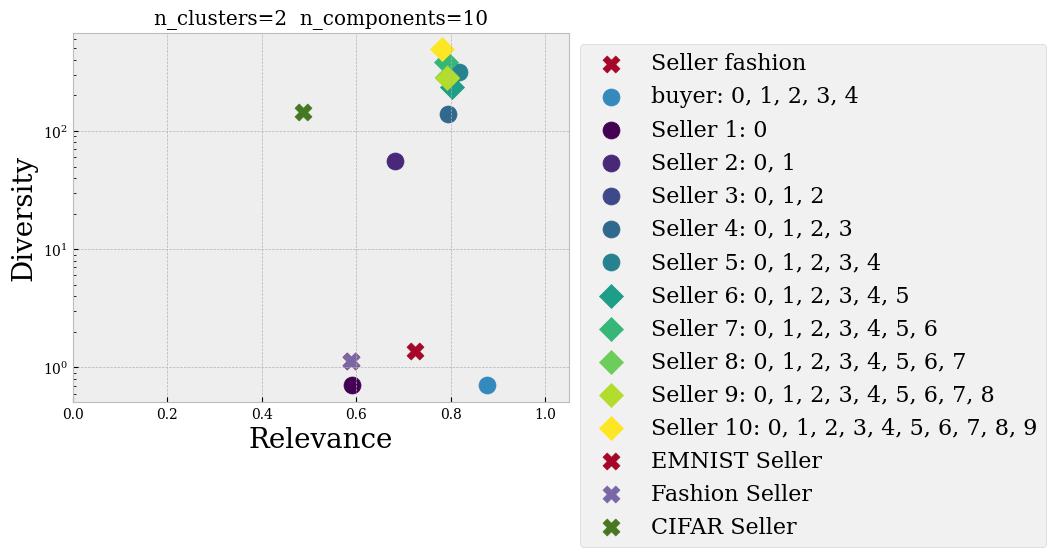

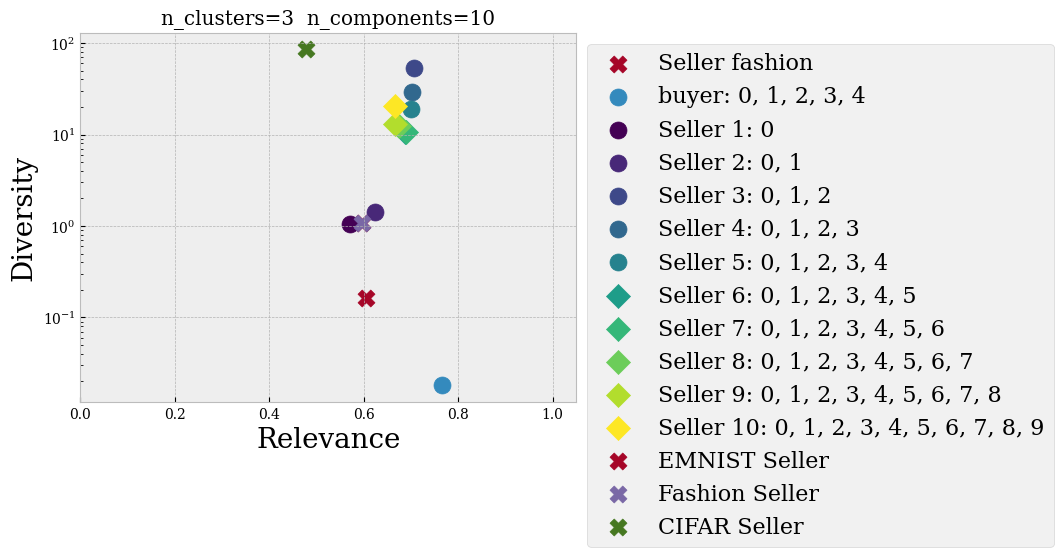

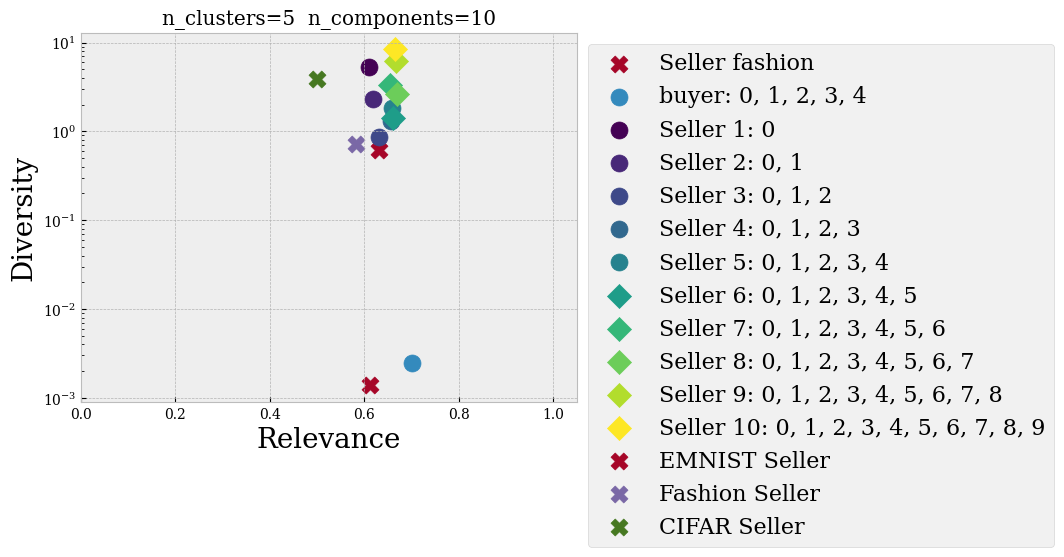

ValueError: n_components=10 must be between 1 and min(n_samples, n_features)=9 with svd_solver='randomized'

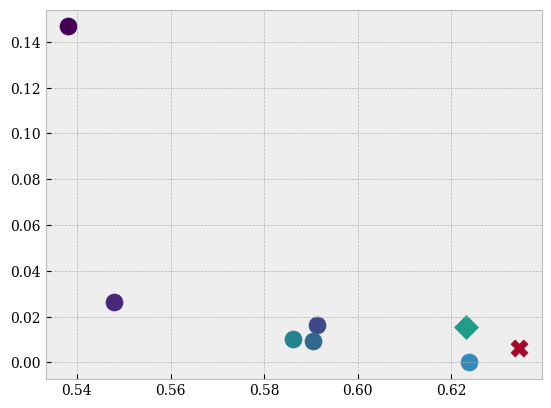

In [187]:
# n_clusters = 10
# n_components = 10

# for n_components in (5, 8, 10, 15, 20):
# for n_clusters in (1, 2, 3, 4, 5, 7, 10, 13, 16):
for n_clusters in (1, 2, 3, 5, 10, 15):
    s = 150
    plt.scatter(*cluster_valuation(buyer_data, np.array(fashion_seller_features, dtype=np.double), n_clusters=n_clusters, n_components=n_components), color='C1', s=s, marker='X', label='Seller fashion')
    plt.scatter(*cluster_valuation(buyer_data, buyer_data, n_clusters=n_clusters, n_components=n_components), label='buyer: 0, 1, 2, 3, 4', s=s, marker='o')
    plt.scatter(*cluster_valuation(buyer_data, seller_1_data, n_clusters=n_clusters, n_components=n_components), color=colors[0], s=s, marker='o', label='Seller 1: 0')
    plt.scatter(*cluster_valuation(buyer_data, seller_2_data, n_clusters=n_clusters, n_components=n_components), color=colors[1], s=s, marker='o', label='Seller 2: 0, 1')
    plt.scatter(*cluster_valuation(buyer_data, seller_3_data, n_clusters=n_clusters, n_components=n_components), color=colors[2], s=s, marker='o', label='Seller 3: 0, 1, 2')
    plt.scatter(*cluster_valuation(buyer_data, seller_4_data, n_clusters=n_clusters, n_components=n_components), color=colors[3], s=s, marker='o', label='Seller 4: 0, 1, 2, 3')
    plt.scatter(*cluster_valuation(buyer_data, seller_5_data, n_clusters=n_clusters, n_components=n_components), color=colors[4], s=s, marker='o', label='Seller 5: 0, 1, 2, 3, 4')
    plt.scatter(*cluster_valuation(buyer_data, seller_6_data, n_clusters=n_clusters, n_components=n_components), color=colors[5], s=s, marker='D', label='Seller 6: 0, 1, 2, 3, 4, 5')
    plt.scatter(*cluster_valuation(buyer_data, seller_7_data, n_clusters=n_clusters, n_components=n_components), color=colors[6], s=s, marker='D', label='Seller 7: 0, 1, 2, 3, 4, 5, 6')
    plt.scatter(*cluster_valuation(buyer_data, seller_8_data, n_clusters=n_clusters, n_components=n_components), color=colors[7], s=s, marker='D', label='Seller 8: 0, 1, 2, 3, 4, 5, 6, 7')
    plt.scatter(*cluster_valuation(buyer_data, seller_9_data, n_clusters=n_clusters, n_components=n_components), color=colors[8], s=s, marker='D', label='Seller 9: 0, 1, 2, 3, 4, 5, 6, 7, 8')
    plt.scatter(*cluster_valuation(buyer_data, seller_10_data, n_clusters=n_clusters, n_components=n_components),color=colors[9], s=s, marker='D', label='Seller 10: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9')
    plt.scatter(*cluster_valuation(buyer_data, emnist_data, n_clusters=n_clusters, n_components=n_components), color='C1', s=s, marker='X', label='EMNIST Seller ')
    plt.scatter(*cluster_valuation(buyer_data, fashion_data, n_clusters=n_clusters, n_components=n_components), color='C2', s=s, marker='X', label='Fashion Seller ')
    plt.scatter(*cluster_valuation(buyer_data, cifar_data, n_clusters=n_clusters, n_components=n_components), color='C3', s=s, marker='X', label='CIFAR Seller ')
    plt.yscale('log')
    plt.xlim(0.0, 1.05)
    plt.xlabel('Relevance', fontsize=20)
    plt.ylabel('Diversity', fontsize=20)
    plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.00, 1.00), ncol=1)
    plt.title(f'{n_clusters=}  {n_components=}')
    # plt.savefig(f'figures/cluster-{n_clusters=}-{n_components=}.png', bbox_inches='tight')
    plt.show()

In [ ]:
num_seller = 10000

emnist_seller_features = torch.cat([model.encode_image(x.cuda()).detach().cpu() for x in tqdm(make_loader(emnist_seller.data[:num_seller]))])
fashion_seller_features = torch.cat([model.encode_image(x.cuda()).detach().cpu() for x in tqdm(make_loader(fashion_seller.data[:num_seller]))])
svhn_seller_features = torch.cat([model.encode_image(x.cuda()).detach().cpu() for x in tqdm(make_loader(np.moveaxis(svhn_seller.data, 1, -1)[:num_seller]))])
cifar_seller_features = torch.cat([model.encode_image(x.cuda()).detach().cpu() for x in tqdm(make_loader(cifar_seller.data[:num_seller]))])

In [67]:
num_buyer = 10000
# num_buyer = 1000
# num_buyer = 100
num_seller = 10000

buyer_data = mnist_buyer_features[subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))][:num_buyer]
seller_1_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', ))][:num_seller]
seller_2_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', '1 - one', ))][:num_seller]
seller_3_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', ))][:num_seller]
seller_4_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', ))][:num_seller]
seller_5_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', ))][:num_seller]
seller_6_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', ))][:num_seller]
seller_7_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', ))][:num_seller]
seller_8_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', ))][:num_seller]
seller_9_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', ))][:num_seller]
seller_10_data = mnist_seller_features[subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))][:num_seller]

emnist_data = emnist_seller_features[subset(emnist_seller, ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'))[:num_seller]]
fashion_data = fashion_seller_features[:num_seller]
svhn_data = svhn_seller_features[:num_seller]
cifar_data = cifar_seller_features[:num_seller]

In [149]:
def get_value(
    buyer_data, seller_data, pca=None, threshold=0.1, n_components=10, 
    verbose=False, norm_volume=True, omega=0.1, dtype = np.float32,
):
    start_time = time.perf_counter()
    buyer_data = np.array(buyer_data, dtype=dtype)
    seller_data = np.array(seller_data, dtype=dtype)
    seller_cov = np.cov(seller_data, rowvar=False)
    buyer_cov = np.cov(buyer_data, rowvar=False)
    buyer_val, buyer_vec = np.linalg.eig(buyer_cov)
    order = np.argsort(buyer_val)[::-1]
    sorted_buyer_val = buyer_val[order]
    sorted_buyer_vec = buyer_vec[:, order]
    buyer_values = sorted_buyer_val.real[:n_components]
    buyer_components = sorted_buyer_vec.real[:, :n_components]
    if verbose:
        print(buyer_components.shape)
    if pca is not None:
        pca.mean_ = None
        seller_values = np.linalg.norm(pca.transform(np.cov(seller_data, rowvar=False)), axis=0)
    else:
        seller_values = np.linalg.norm(seller_cov @ buyer_components, axis=0)
    if verbose:
        print(seller_values.shape)
        
    # only include directions with value above this threshold
    if verbose: print(f'{seller_values=}')
    keep_mask = buyer_values >= threshold
    if verbose: print(f'{keep_mask.nonzero()[0].shape[0]=}')
    C = np.maximum(buyer_values, seller_values)  
    div_components = np.abs(buyer_values - seller_values) / C
    rel_components = np.minimum(buyer_values, seller_values) / C
    div = np.prod(np.where(keep_mask, div_components, 1)) ** (1 / keep_mask.sum())
    rel = np.prod(np.where(keep_mask, rel_components, 1)) ** (1 / keep_mask.sum())
    if verbose:
        print(np.prod(seller_values))

    if norm_volume:
        Norm = Normalizer(norm='l2')
        seller_data = Norm.fit_transform(seller_data)
    vol = valuation.get_volume(seller_data @ buyer_components, omega=omega)
        
    end_time = time.perf_counter()
    if verbose:
        print('time', end_time - start_time)
    return dict(diversity=div, relevance=rel, volume=vol)

In [151]:
n_components = 10
print(get_value(buyer_data, buyer_data, n_components=n_components, verbose=True))
print(get_value(buyer_data, seller_5_data, n_components=n_components, verbose=True))
# print()
# print(get_value(buyer_data, buyer_data, n_components=n_components, pca=pca, verbose=True))
# print(get_value(buyer_data, seller_5_data, n_components=n_components, pca=pca, verbose=True))

(512, 10)
(10,)
seller_values=array([1.01801012, 0.71972371, 0.38037411, 0.36980142, 0.23868521,
       0.19962699, 0.14809497, 0.10960167, 0.10032313, 0.09142602])
keep_mask.nonzero()[0].shape[0]=9
7.310895447069476e-07
time 2.9204430244863033
{'diversity': 2.8110212286012777e-15, 'relevance': 0.9999999999999964, 'volume': 2108.455}
(512, 10)
(10,)
seller_values=array([0.96473637, 0.75157036, 0.3686341 , 0.37356244, 0.22122012,
       0.20493213, 0.14700016, 0.11295541, 0.09767037, 0.10139385])
keep_mask.nonzero()[0].shape[0]=9
7.443393286402949e-07
time 2.586625102907419
{'diversity': 0.02698018987291693, 'relevance': 0.9666690506116394, 'volume': 6749.062}


In [42]:
# number of PCA components to use
# n_components = 2
# n_components = 5
n_components = 10
# n_components = 15
# n_components = 20
# n_components = 50

# whether to use pretrained image features or raw data
use_features = True 
# use_features = False

In [166]:
X_b = buyer_data.float() 

# X_b -= X_b.mean(0) 
Norm = Normalizer(norm='l2')

buyer_cov = np.cov(X_b, rowvar=False)

# eigendecomposition of buyer's covariance matrix
buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)

# sort by decreasing eigenvalues
sorted_indices = np.argsort(buyer_eig_val)[::-1]
buyer_values = buyer_eig_val[sorted_indices].real
buyer_components = buyer_eig_vec[:, sorted_indices].real

print(f'first {n_components} components using numpy:', buyer_values[:n_components])

# project seller 1 data onto buyer's components
np.linalg.norm(X_b @ buyer_components[:, :n_components], axis=0)
# np.linalg.norm(np.cov(Normalizer().fit_transform(seller_1_data), rowvar=False) @ buyer_components[:, :n_components], axis=0)
# np.linalg.norm(seller_1_data @ buyer_components[:, :n_components], axis=0)
# X_1 = Norm.fit_transform(seller_1_data.clone())

first 10 components using numpy: [1343.26002919  292.01169207  206.64492988  157.04520172  142.86923678
  125.75681806   77.39851687   70.28149942   56.33110029   52.0405795 ]


array([406.82982276, 171.21160374, 175.43021985, 181.84730513,
       126.58768033, 145.02428349, 185.27414679, 157.82647042,
       107.43322984, 150.92569573])

**We can also use sklearn's implmentation of PCA to get the same results**

In [154]:
X_b = buyer_data


pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
pca.fit(X_b)

buyer_values = pca.explained_variance_
buyer_components = pca.components_

print(f'first {n_components} components using sklearn:', buyer_values)
np.linalg.norm(pca.transform(X_b), axis=0)
# pca.transform(X_b)

first 10 components using sklearn: [1343.26002919  292.01169206  206.64492988  157.04520166  142.86923657
  125.75681695   77.3985105    70.28138443   56.33037755   52.03993793]


array([364.66798994, 170.02693173, 143.03093392, 124.68951425,
       118.92877877, 111.57923139,  87.53543591,  83.4137702 ,
        74.67735519,  71.77711233])

In [34]:
X_1 = seller1_features if use_features else seller1_data_flat.float()
X_1 -= X_1.mean(0)
seller1_cov = np.cov(X_1.T)

X_2 = seller2_features if use_features else seller2_data_flat.float()
X_2 -= X_2.mean(0)
seller2_cov = np.cov(X_2.T)

X_3 = seller3_features if use_features else seller3_data_flat.float()
X_3 -= X_3.mean(0)
seller3_cov = np.cov(X_3.T)

X_4 = seller4_features if use_features else seller4_data_flat.float()
X_4 -= X_4.mean(0)
seller4_cov = np.cov(X_4.T)

X_5 = seller5_features if use_features else seller5_data_flat.float()
X_5 -= X_5.mean(0)
seller5_cov = np.cov(X_5.T)

X_6 = seller6_features if use_features else seller6_data_flat.float()
X_6 -= X_6.mean(0)
seller6_cov = np.cov(X_6.T)

X_7 = seller7_features if use_features else seller7_data_flat.float()
X_7 -= X_7.mean(0)
seller7_cov = np.cov(X_7.T)

X_8 = seller8_features if use_features else seller8_data_flat.float()
X_8 -= X_8.mean(0)
seller8_cov = np.cov(X_8.T)

X_9 = seller9_features if use_features else seller9_data_flat.float()
X_9 -= X_9.mean(0)
seller9_cov = np.cov(X_9.T)

X_10 = seller10_features if use_features else seller10_data_flat.float()
X_10 -= X_10.mean(0)
seller10_cov = np.cov(X_10.T)

X_11 = seller11_features if use_features else seller11_data_flat.float()
X_11 -= X_11.mean(0)
seller11_cov = np.cov(X_11.T)

X_12 = seller12_features if use_features else seller12_data_flat.float()
X_12 -= X_12.mean(0)
seller12_cov = np.cov(X_12.T)

X_13 = seller13_features if use_features else seller13_data_flat.float()
X_13 -= X_13.mean(0)
seller13_cov = np.cov(X_13.T)

X_fashion = seller_fashion_features if use_features else seller_fashion_data_flat.float()
X_fashion -= X_fashion.mean(0)
seller_fashion_cov = np.cov(X_fashion.T)

X_cifar = seller_cifar_features if use_features else seller_cifar_data_flat.float()
X_cifar -= X_cifar.mean(0)
seller_cifar_cov = np.cov(X_cifar.T)

X_emnist = seller_emnist_features if use_features else seller_emnist_data_flat.float()
X_emnist -= X_emnist.mean(0)
seller_emnist_cov = np.cov(X_emnist.T)


In [35]:
X_dup1 = dup1_features if use_features else dup1_data_flat.float()
X_dup1 -= X_dup1.mean(0)
dup1_cov = np.cov(X_dup1.T)

X_dup2 = dup2_features if use_features else dup2_data_flat.float()
X_dup2 -= X_dup2.mean(0)
dup2_cov = np.cov(X_dup2.T)

X_dup3 = dup3_features if use_features else dup3_data_flat.float()
X_dup3 -= X_dup3.mean(0)
dup3_cov = np.cov(X_dup3.T)

X_dup4 = dup4_features if use_features else dup4_data_flat.float()
X_dup4 -= X_dup4.mean(0)
dup4_cov = np.cov(X_dup4.T)

X_mix1 = mix1_features if use_features else mix1_data_flat.float()
X_mix1 -= X_mix1.mean(0)
mix1_cov = np.cov(X_mix1.T)

X_mix2 = mix2_features if use_features else mix2_data_flat.float()
X_mix2 -= X_mix2.mean(0)
mix2_cov = np.cov(X_mix2.T)

X_mix3 = mix3_features if use_features else mix3_data_flat.float()
X_mix3 -= X_mix3.mean(0)
mix3_cov = np.cov(X_mix3.T)

X_mix4 = mix4_features if use_features else mix4_data_flat.float()
X_mix4 -= X_mix4.mean(0)
mix4_cov = np.cov(X_mix4.T)

X_mix5 = mix5_features if use_features else mix5_data_flat.float()
X_mix5 -= X_mix5.mean(0)
mix5_cov = np.cov(X_mix5.T)

X_mix6 = mix6_features if use_features else mix6_data_flat.float()
X_mix6 -= X_mix6.mean(0)
mix6_cov = np.cov(X_mix6.T)

X_mix7 = mix7_features if use_features else mix7_data_flat.float()
X_mix7 -= X_mix7.mean(0)
mix7_cov = np.cov(X_mix7.T)

X_mix8 = mix8_features if use_features else mix8_data_flat.float()
X_mix8 -= X_mix8.mean(0)
mix8_cov = np.cov(X_mix8.T)

X_mix9 = mix9_features if use_features else mix9_data_flat.float()
X_mix9 -= X_mix9.mean(0)
mix9_cov = np.cov(X_mix9.T)

### Compute volume-based diversity measure on projected data

In [36]:
# normalize samples (rows) to have unit norm
normalize = True
if normalize:
    Norm = Normalizer(norm='l2')
    X_1 = Norm.fit_transform(X_1.clone())
    X_2 = Norm.fit_transform(X_2.clone())
    X_3 = Norm.fit_transform(X_3.clone())
    X_4 = Norm.fit_transform(X_4.clone())
    X_5 = Norm.fit_transform(X_5.clone())
    X_6 = Norm.fit_transform(X_6.clone())
    X_7 = Norm.fit_transform(X_7.clone())
    X_8 = Norm.fit_transform(X_8.clone())
    X_9 = Norm.fit_transform(X_9.clone())
    X_10 = Norm.fit_transform(X_10.clone())
    X_11 = Norm.fit_transform(X_11.clone())
    X_12 = Norm.fit_transform(X_12.clone())
    X_13 = Norm.fit_transform(X_13.clone())
    X_fashion = Norm.fit_transform(X_fashion.clone())
    X_emnist = Norm.fit_transform(X_emnist.clone())
    X_cifar = Norm.fit_transform(X_cifar.clone())
    X_dup1 = Norm.fit_transform(X_dup1.clone())
    X_dup2 = Norm.fit_transform(X_dup2.clone())
    X_dup3 = Norm.fit_transform(X_dup3.clone())
    X_dup4 = Norm.fit_transform(X_dup4.clone())
    X_mix1 = Norm.fit_transform(X_mix1.clone())
    X_mix2 = Norm.fit_transform(X_mix2.clone())
    X_mix3 = Norm.fit_transform(X_mix3.clone())
    X_mix4 = Norm.fit_transform(X_mix4.clone())
    X_mix5 = Norm.fit_transform(X_mix5.clone())
    X_mix6 = Norm.fit_transform(X_mix6.clone())
    X_mix7 = Norm.fit_transform(X_mix7.clone())
    X_mix8 = Norm.fit_transform(X_mix8.clone())
    X_mix9 = Norm.fit_transform(X_mix9.clone())

In [37]:
# hyperparameter for volume-based diversity meausre 
# controls robustness to data duplication
# in range (0, 1); higher values increase robustness
# see paper for more info https://proceedings.neurips.cc/paper/2021/hash/59a3adea76fadcb6dd9e54c96fc155d1-Abstract.html

omegas = np.arange(0.1, 1, 0.2)
vol_full = [get_volume(pca.transform(X_1), omega=omega) for omega in omegas]
vol_dup1 = [get_volume(pca.transform(X_dup1), omega=omega) for omega in omegas]
vol_dup2 = [get_volume(pca.transform(X_dup2), omega=omega) for omega in omegas]
vol_dup3 = [get_volume(pca.transform(X_dup3), omega=omega) for omega in omegas]
vol_dup4 = [get_volume(pca.transform(X_dup4), omega=omega) for omega in omegas]

Text(0, 0.5, 'Volume')

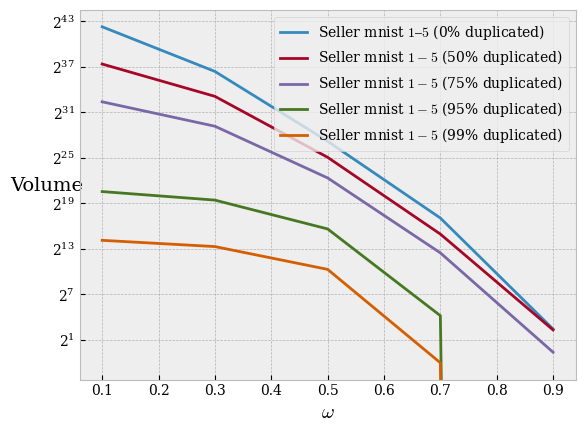

In [38]:
plt.figure()
plt.plot(omegas, vol_full, label=r'Seller mnist $1–5$ (0% duplicated)')
plt.plot(omegas, vol_dup1, label=r'Seller mnist $1-5$ (50% duplicated)')
plt.plot(omegas, vol_dup2, label=r'Seller mnist $1-5$ (75% duplicated)')
plt.plot(omegas, vol_dup3, label=r'Seller mnist $1-5$ (95% duplicated)')
plt.plot(omegas, vol_dup4, label=r'Seller mnist $1-5$ (99% duplicated)')
plt.legend()
plt.yscale('log', base=2)
plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel(r'Volume', fontsize=14, rotation=0)

In [39]:
omega = 0.1
# omega = 0.3
# omega = 0.5
# omega = 0.7

buyer_vol = get_volume(pca.transform(X_b), omega=omega)
seller1_vol = get_volume(pca.transform(X_1), omega=omega) 
seller2_vol = get_volume(pca.transform(X_2), omega=omega) 
seller3_vol = get_volume(pca.transform(X_3), omega=omega) 
seller4_vol = get_volume(pca.transform(X_4), omega=omega) 
seller5_vol = get_volume(pca.transform(X_5), omega=omega) 
seller6_vol = get_volume(pca.transform(X_6), omega=omega) 
seller7_vol = get_volume(pca.transform(X_7), omega=omega) 
seller8_vol = get_volume(pca.transform(X_8), omega=omega) 
seller9_vol = get_volume(pca.transform(X_9), omega=omega) 
seller10_vol = get_volume(pca.transform(X_10), omega=omega) 
seller11_vol = get_volume(pca.transform(X_11), omega=omega) 
seller12_vol = get_volume(pca.transform(X_12), omega=omega) 
seller13_vol = get_volume(pca.transform(X_13), omega=omega) 
seller_fashion_vol = get_volume(pca.transform(X_fashion), omega=omega) 
seller_emnist_vol = get_volume(pca.transform(X_emnist), omega=omega) 
if use_features:
    seller_cifar_vol = get_volume(pca.transform(X_cifar), omega=omega) 
dup1_vol = get_volume(pca.transform(X_dup1), omega=omega) 
dup2_vol = get_volume(pca.transform(X_dup2), omega=omega) 
dup3_vol = get_volume(pca.transform(X_dup3), omega=omega) 
dup4_vol = get_volume(pca.transform(X_dup4), omega=omega) 
mix1_vol = get_volume(pca.transform(X_mix1), omega=omega) 
mix2_vol = get_volume(pca.transform(X_mix2), omega=omega) 
mix3_vol = get_volume(pca.transform(X_mix3), omega=omega) 
mix4_vol = get_volume(pca.transform(X_mix4), omega=omega) 
mix5_vol = get_volume(pca.transform(X_mix5), omega=omega) 
mix6_vol = get_volume(pca.transform(X_mix6), omega=omega) 
mix7_vol = get_volume(pca.transform(X_mix7), omega=omega) 
mix8_vol = get_volume(pca.transform(X_mix8), omega=omega) 
mix9_vol = get_volume(pca.transform(X_mix9), omega=omega) 

In [40]:
# only consider directions where the eigenvalue is larger than this threshold in the computation of diversity and relevance
threshold = 0.1
# threshold = 0.2
# threshold = 0.3

kwargs = {'threshold': threshold, 'n_components': n_components}

In [46]:
# where to save plots
figures = Path('figures')
figures.mkdir(exist_ok=True, parents=True)

### Compare diversity measures when sellers have different amounts of overlapping classes

/tmp/ipykernel_66352/3534849498.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/3534849498.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/3534849498.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/3534849498.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


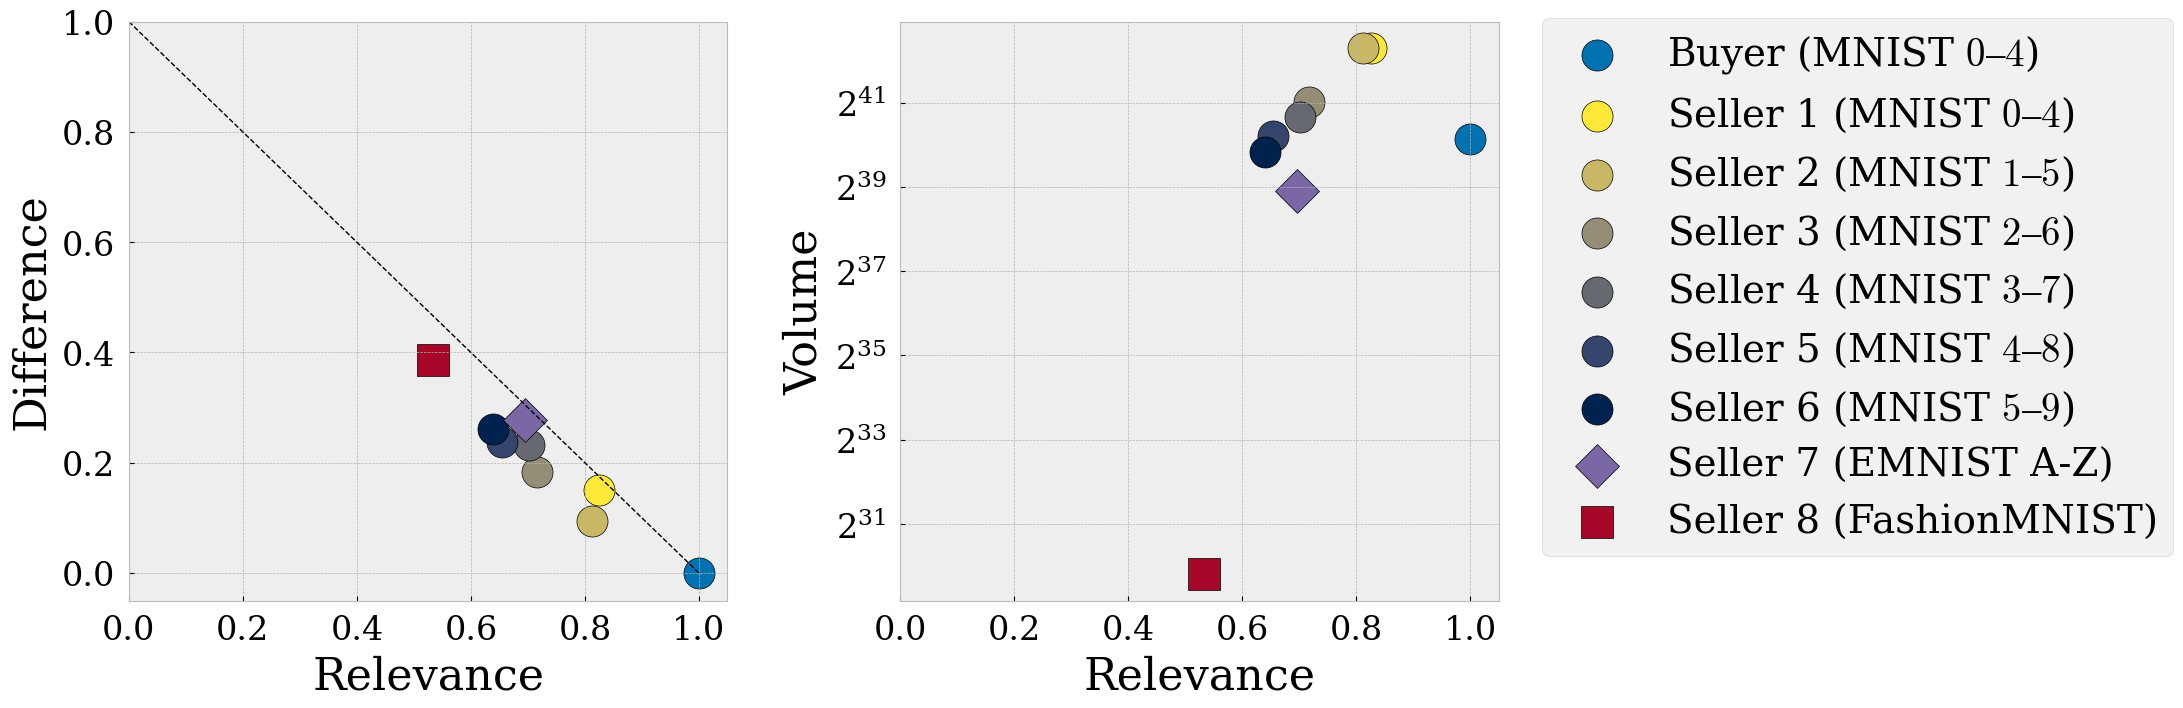

In [48]:
cividis = [np.array([matplotlib.colormaps['cividis'].colors[int(k)]]) for k in np.linspace(255, 0, 6)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(16, 8), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=cividis[0], edgecolor='k', s=s, label=r'Seller mnist $0–4$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs), c=cividis[1], edgecolor='k', s=s, label=r'Seller mnist $1–5$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs), c=cividis[2], edgecolor='k', s=s, label=r'Seller mnist $2–6$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs), c=cividis[3], edgecolor='k', s=s, label=r'Seller mnist $3–7$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs), c=cividis[4], edgecolor='k', s=s, label=r'Seller mnist $4–8$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs), c=cividis[5], edgecolor='k', s=s, label=r'Seller mnist $5–9$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D', label=r'Seller emnist')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s', label=r'Seller fashion')
if use_features:
    ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^', label=r'Seller Cifar')

ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(-0.05, 1)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=cividis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs)[0], seller1_vol, c=cividis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $1–5$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs)[0], seller2_vol, c=cividis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $2–6$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs)[0], seller3_vol, c=cividis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $3–7$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs)[0], seller4_vol, c=cividis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $4–8$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller5_vol, c=cividis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $5–9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 7 (EMNIST A-Z)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 8 (FashionMNIST)')
if use_features:
    ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[1].set_xlim(0, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-4}, bbox_to_anchor=(1.04, 1.04))
plt.savefig(figures / f'mnist-compare-diversity-overlap-{"features-" if use_features else ""}n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have increasing number of unique classes

/tmp/ipykernel_66352/1513436620.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/1513436620.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/1513436620.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/1513436620.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


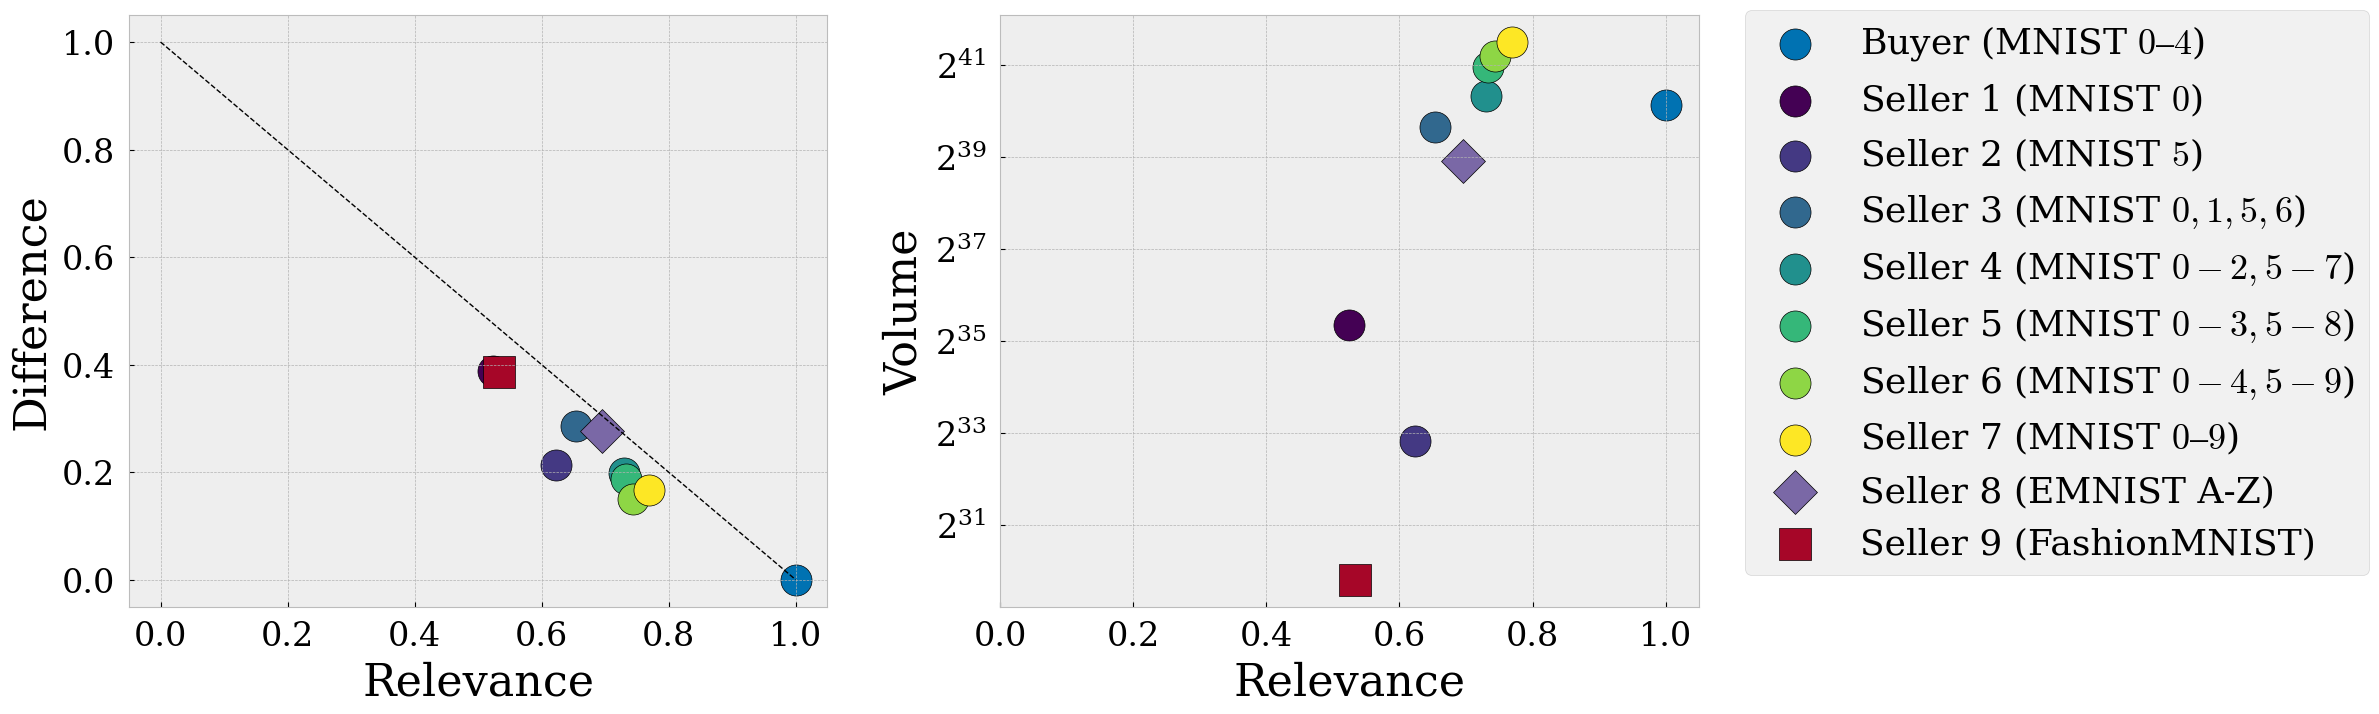

In [49]:
viridis = [np.array([matplotlib.colormaps['viridis'].colors[int(k)]]) for k in np.linspace(0, 255, 7)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs), c=viridis[0], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs), c=viridis[1], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs), c=viridis[2], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs), c=viridis[3], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs), c=viridis[4], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs), c=viridis[5], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs), c=viridis[6], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s')
if use_features:
    ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^')

# ax[0].set_xlim(0.5, 1.05)
# ax[0].set_ylim(-0.02, 0.5)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs)[0], seller7_vol, c=viridis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs)[0], seller8_vol, c=viridis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $5$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs)[0], seller9_vol, c=viridis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $0, 1, 5, 6$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs)[0], seller10_vol, c=viridis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $0-2, 5-7$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs)[0], seller11_vol, c=viridis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $0-3, 5-8$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs)[0], seller12_vol, c=viridis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $0-4, 5-9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs)[0], seller13_vol, c=viridis[6], edgecolor='k', s=s, label=r'Seller 7 (MNIST $0–9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 8 (EMNIST A-Z)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 9 (FashionMNIST)')
if use_features:
    ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[1].set_xlim(0.0, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.04, 1.04))
plt.savefig(figures / f'mnist-compare-diversity-classes-{"features-" if use_features else ""}n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have increasing amount of duplicated data

/tmp/ipykernel_66352/1192011452.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/1192011452.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/1192011452.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/1192011452.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


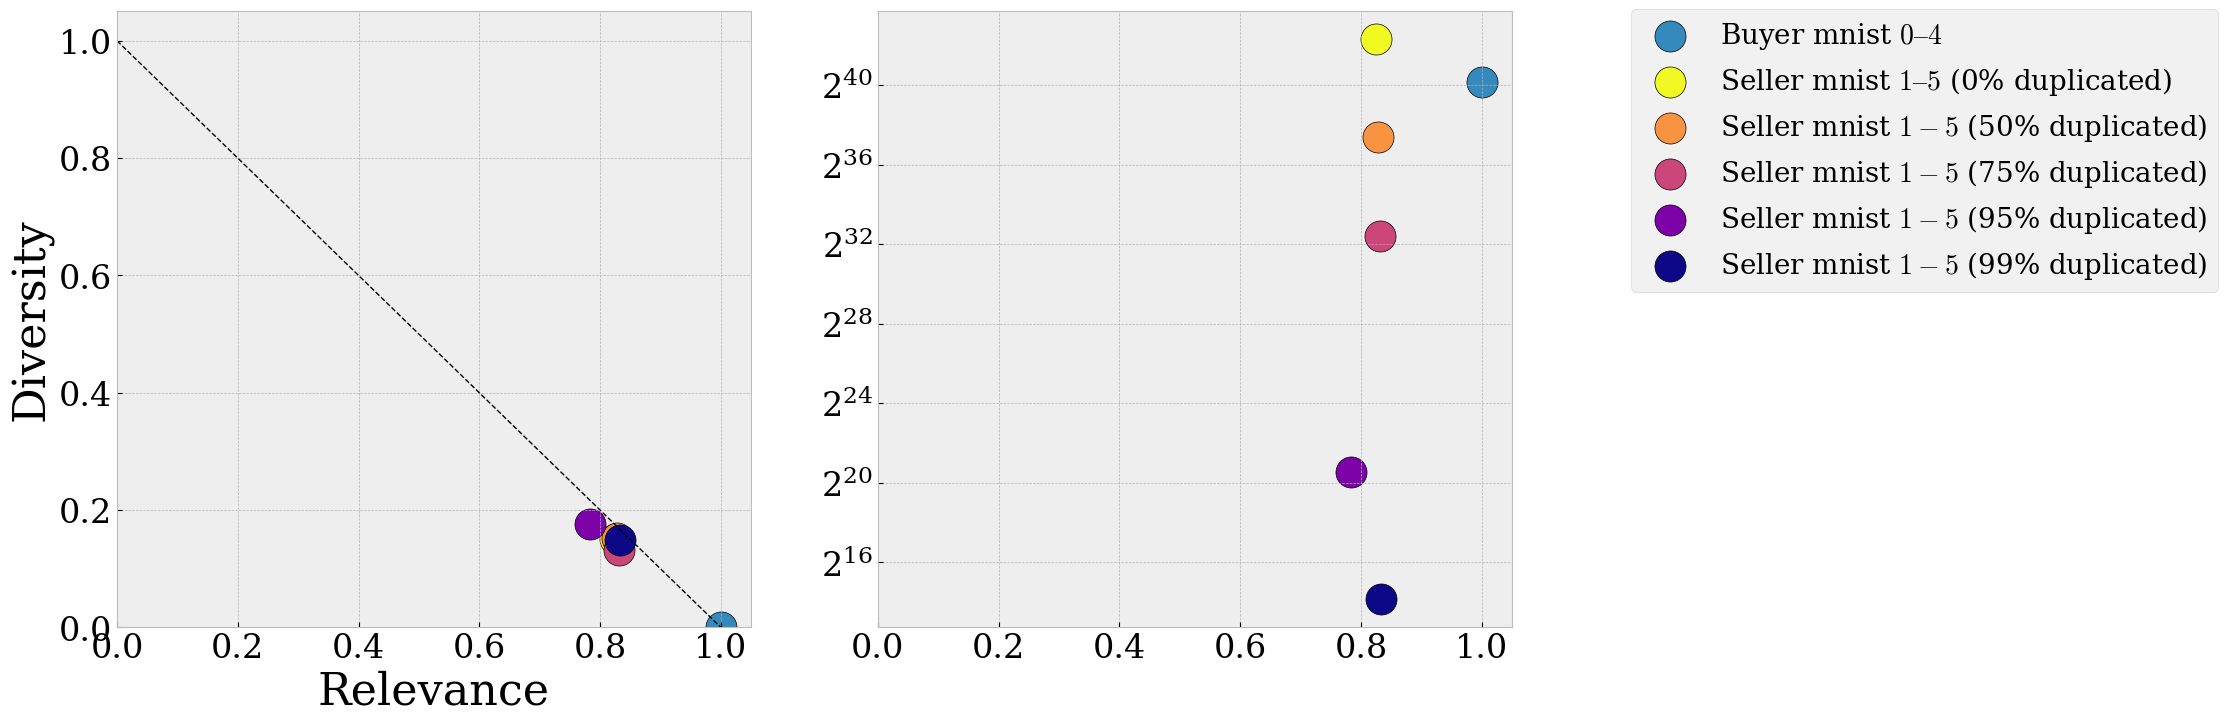

In [50]:
plasma = np.array([matplotlib.colormaps['plasma'].colors[int(k)] for k in np.linspace(255, 0, 5)])[:, None]

s = 500
fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1–5$ (0% duplicated)')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs), c=plasma[1], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (50% duplicated)')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs), c=plasma[2], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (75% duplicated)')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs), c=plasma[3], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (95% duplicated)')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs), c=plasma[4], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (99% duplicated)')
ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(0, 1.05)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=32)
ax[0].set_ylabel('Diversity', fontsize=32)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=plasma[0], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs)[0], dup1_vol, c=plasma[1], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs)[0], dup2_vol, c=plasma[2], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs)[0], dup3_vol, c=plasma[3], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs)[0], dup4_vol, c=plasma[4], edgecolor='k', s=s)
ax[1].set_xlim(0, 1.05)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log', base=2)
fig.legend(prop={'size': 20}, bbox_to_anchor=(1.30, 0.90))
plt.savefig(figures / f'mnist-compare-diversity-duplication-{"features-" if use_features else ""}n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have mixed MNIST / FashionMNIST data

/tmp/ipykernel_66352/1193916971.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/1193916971.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/1193916971.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_66352/1193916971.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


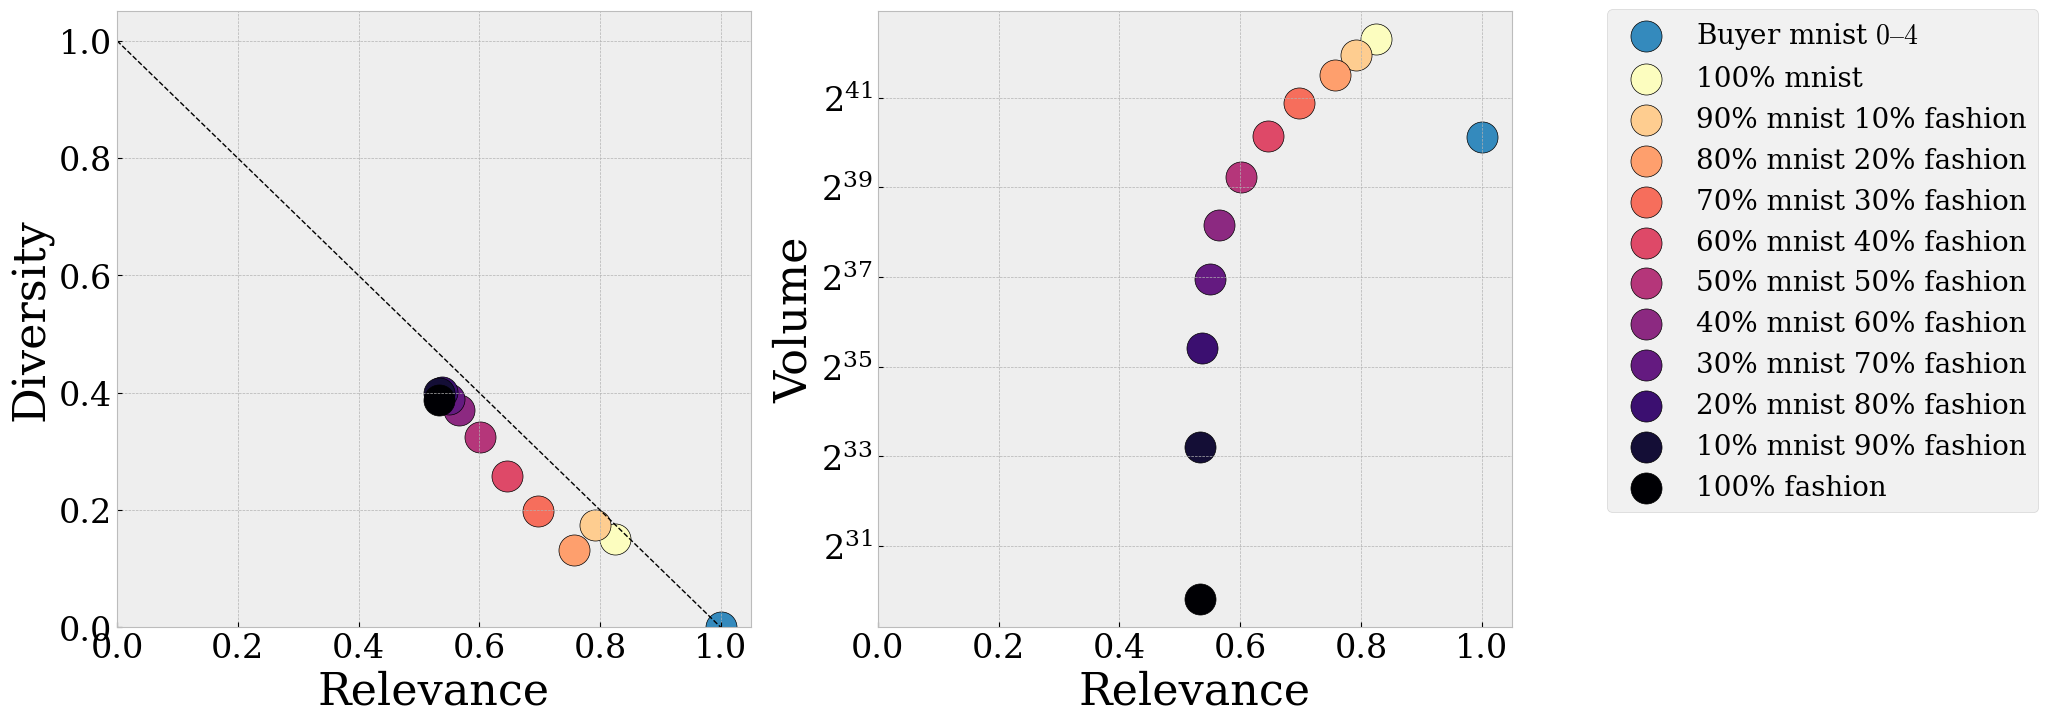

In [51]:
magma = [[matplotlib.colormaps['magma'].colors[int(k)]] for k in np.linspace(255, 0, 11)]


s = 500
fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='C0', edgecolor='k', s=s, label=r'Buyer mnist $0–4$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=magma[0], edgecolor='k', s=s, label=r'100% mnist')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs), c=magma[1], edgecolor='k', s=s, label=r'90% mnist 10% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs), c=magma[2], edgecolor='k', s=s, label=r'80% mnist 20% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs), c=magma[3], edgecolor='k', s=s, label=r'70% mnist 30% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs), c=magma[4], edgecolor='k', s=s, label=r'60% mnist 40% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs), c=magma[5], edgecolor='k', s=s, label=r'50% mnist 50% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs), c=magma[6], edgecolor='k', s=s, label=r'40% mnist 60% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs), c=magma[7], edgecolor='k', s=s, label=r'30% mnist 70% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs), c=magma[8], edgecolor='k', s=s, label=r'20% mnist 80% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs), c=magma[9], edgecolor='k', s=s, label=r'10% mnist 90% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c=magma[10], edgecolor='k', s=s, label=r'100% fashion')
ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(0, 1.05)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=32)
ax[0].set_ylabel('Diversity', fontsize=32)
# plt.savefig(f'mnist-diversity-mix.png', bbox_inches='tight')

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,  c='C0', edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=magma[0], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs)[0], mix1_vol, c=magma[1], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs)[0], mix2_vol, c=magma[2], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs)[0], mix3_vol, c=magma[3], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs)[0], mix4_vol, c=magma[4], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs)[0], mix5_vol, c=magma[5], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs)[0], mix6_vol, c=magma[6], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs)[0], mix7_vol, c=magma[7], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs)[0], mix8_vol, c=magma[8], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs)[0], mix9_vol, c=magma[9], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c=magma[10], edgecolor='k', s=s)
ax[1].set_xlim(0, 1.05)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
# plt.ylim(0, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32)
ax[1].set_ylabel('Volume', fontsize=32)
fig.legend(prop={'size': 20}, bbox_to_anchor=(1.20, 0.90))
plt.savefig(figures / f'mnist-compare-diversity-mixed-{"features-" if use_features else ""}n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()
